In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
X_train_res = pd.read_csv('X_train_res.csv')
y_train_res = pd.read_csv('y_train_res.csv').squeeze()
X_test_res = pd.read_csv('X_test_res.csv')
y_test_res = pd.read_csv('y_test_res.csv').squeeze()

pca = PCA(n_components=30)
X_train_reduced = pca.fit_transform(X_train_res)
X_test_reduced = pca.transform(X_test_res)

xgboost_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgboost_model.fit(X_train_reduced, y_train_res)

y_pred_class = xgboost_model.predict(X_test_reduced)
selected_indices = (y_pred_class == 1)
X_test_filtered = X_test_res.iloc[selected_indices].copy()

if 'ArrDel15' in X_test_filtered.columns:
    X_test_filtered.drop(columns=['ArrDel15'], inplace=True)

X_train_res_regression = pd.read_csv('X_train_res_regression.csv')
y_train_res_regression = pd.read_csv('y_train_res_regression.csv').squeeze()
X_test_res_regression = pd.read_csv('X_test_res_regression.csv')
y_test_res_regression = pd.read_csv('y_test_res_regression.csv').squeeze()

X_test_res_filtered = X_test_res_regression.iloc[selected_indices].copy()
y_test_res_filtered = y_test_res_regression.iloc[selected_indices].copy()

if 'ArrDel15' in X_test_res_filtered.columns:
    X_test_res_filtered.drop(columns=['ArrDel15'], inplace=True)

X_test_res_filtered = X_test_res_filtered[X_train_res_regression.columns]

ranges = [(0, 15), (15, 199), (200, 399), (400, 599), (600, 799), (800, 999), (1000, float('inf'))]

models = {}
predictions = {}

for low, high in ranges:
    range_train = (y_train_res_regression >= low) & (y_train_res_regression < high)
    range_test = (y_test_res_filtered >= low) & (y_test_res_filtered < high)

    X_train_range = X_train_res_regression[range_train]
    y_train_range = y_train_res_regression[range_train]
    X_test_range = X_test_res_filtered[range_test]
    y_test_range = y_test_res_filtered[range_test]

    if len(X_train_range) > 0 and len(X_test_range) > 0:
        X_test_range = X_test_range[X_train_range.columns]

        best_model = ExtraTreesRegressor(n_estimators=500, max_depth=15, random_state=42)
        best_model.fit(X_train_range, y_train_range)

        models[(low, high)] = best_model
        predictions[(low, high)] = {
            "y_pred": best_model.predict(X_test_range),
            "y_test": y_test_range,
        }

y_pred_optimized = np.full_like(y_test_res_filtered, np.nan)

for (low, high), pred in predictions.items():
    range_test = (y_test_res_filtered >= low) & (y_test_res_filtered < high)
    y_pred_optimized[range_test] = pred["y_pred"]

valid_indices = ~np.isnan(y_pred_optimized) & ~np.isnan(y_test_res_filtered)
y_test_clean = y_test_res_filtered[valid_indices]
y_pred_clean = y_pred_optimized[valid_indices]

final_mse = mean_squared_error(y_test_clean, y_pred_clean)
final_r2 = r2_score(y_test_clean, y_pred_clean)
final_mae = mean_absolute_error(y_test_clean, y_pred_clean)

print("Optimized Model Performance:")
print(f"Overall R² Score: {final_r2:.4f}")
print(f"Overall Mean Squared Error: {final_mse:.4f}")
print(f"Overall Mean Absolute Error: {final_mae:.4f}")

for low, high in ranges:
    range_indices = (y_test_res_filtered >= low) & (y_test_res_filtered < high)
    valid_range_indices = range_indices & valid_indices

    if valid_range_indices.sum() > 0:
        r2 = r2_score(y_test_res_filtered[valid_range_indices], y_pred_optimized[valid_range_indices])
        mae = mean_absolute_error(y_test_res_filtered[valid_range_indices], y_pred_optimized[valid_range_indices])
        mse = mean_squared_error(y_test_res_filtered[valid_range_indices], y_pred_optimized[valid_range_indices])
        print(f"Range {low}-{high}:")
        print(f"  R²: {r2:.4f}")
        print(f"  MAE: {mae:.4f}")
        print(f"  MSE: {mse:.4f}")

pd.DataFrame({
    'y_test': y_test_clean,
    'y_pred_optimized': y_pred_clean
}).to_csv('final_predictions.csv', index=False)

C:\Users\Rohit\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:24:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Optimized Model Performance:
Overall R² Score: 0.9641
Overall Mean Squared Error: 186.6134
Overall Mean Absolute Error: 9.4094
Range 0-15:
  R²: 0.1643
  MAE: 3.8617
  MSE: 20.5472
Range 15-199:
  R²: 0.8767
  MAE: 9.7859
  MSE: 196.5184
Range 200-399:
  R²: 0.8802
  MAE: 12.4931
  MSE: 309.6253
Range 400-599:
  R²: 0.8901
  MAE: 12.6101
  MSE: 354.7669
Range 600-799:
  R²: 0.9428
  MAE: 10.7244
  MSE: 199.9831
Range 800-999:
  R²: 0.9126
  MAE: 11.8679
  MSE: 250.6460
Range 1000-inf:
  R²: 0.9903
  MAE: 14.0981
  MSE: 368.5197


In [3]:
ranges = [(15, 199), (200, 399), (400, 599), (600, 799), (800, 999), (1000, float('inf'))]

metrics_by_range = []

for low, high in ranges:
    range_indices = (y_test_res_filtered >= low) & (y_test_res_filtered < high)
    
    y_test_range = y_test_res_filtered[range_indices]
    y_pred_range = y_pred_optimized[range_indices]
    
    r2 = r2_score(y_test_range, y_pred_range) if len(y_test_range) > 0 else np.nan
    mae = mean_absolute_error(y_test_range, y_pred_range) if len(y_test_range) > 0 else np.nan
    mse = mean_squared_error(y_test_range, y_pred_range) if len(y_test_range) > 0 else np.nan
    
    frequency = len(y_test_range)
    
    metrics_by_range.append({
        'Range': f"{int(low)}{f'-{int(high)}' if high != float('inf') else '+'}",
        'Frequency': frequency,
        'R²': r2,
        'MAE': mae,
        'MSE': mse
    })

metrics_df = pd.DataFrame(metrics_by_range)

print(metrics_df)

     Range  Frequency        R²        MAE         MSE
0   15-199     283217  0.876712   9.785886  196.518434
1  200-399      10207  0.880197  12.493116  309.625326
2  400-599       1101  0.890078  12.610064  354.766853
3  600-799        356  0.942753  10.724374  199.983108
4  800-999        250  0.912563  11.867859  250.646031
5    1000+        135  0.990269  14.098080  368.519745


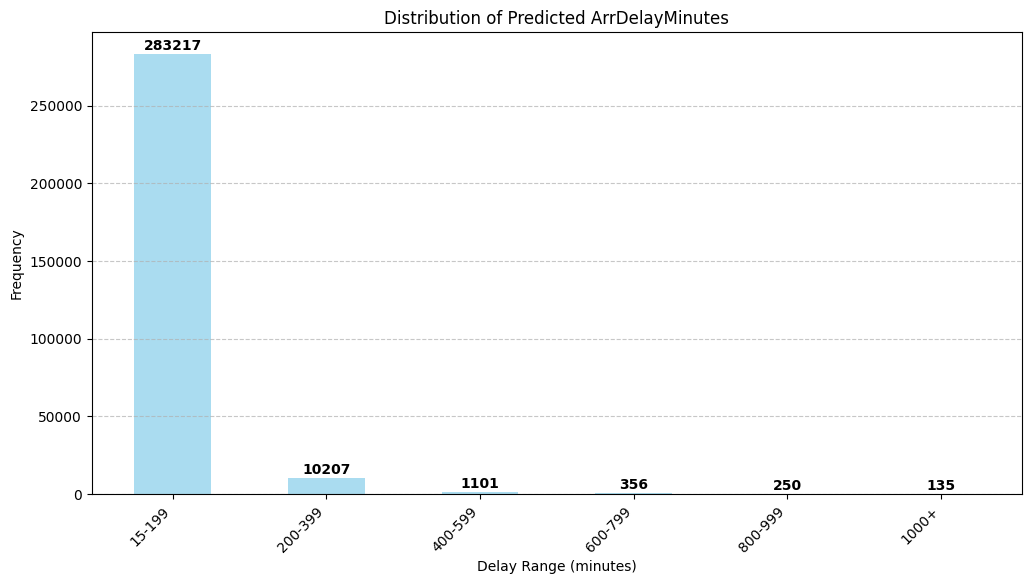

In [4]:
plt.figure(figsize=(12, 6))

x_labels = metrics_df['Range']
x = np.arange(len(x_labels))  

plt.bar(x, metrics_df['Frequency'], width=0.5, color='skyblue', alpha=0.7)

for i, freq in enumerate(metrics_df['Frequency']):
    plt.text(x[i], freq + 0.01 * max(metrics_df['Frequency']), f'{freq}',
             ha='center', fontsize=10, fontweight='bold')

plt.xticks(ticks=x, labels=x_labels, rotation=45, ha='right')
plt.xlabel('Delay Range (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted ArrDelayMinutes')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

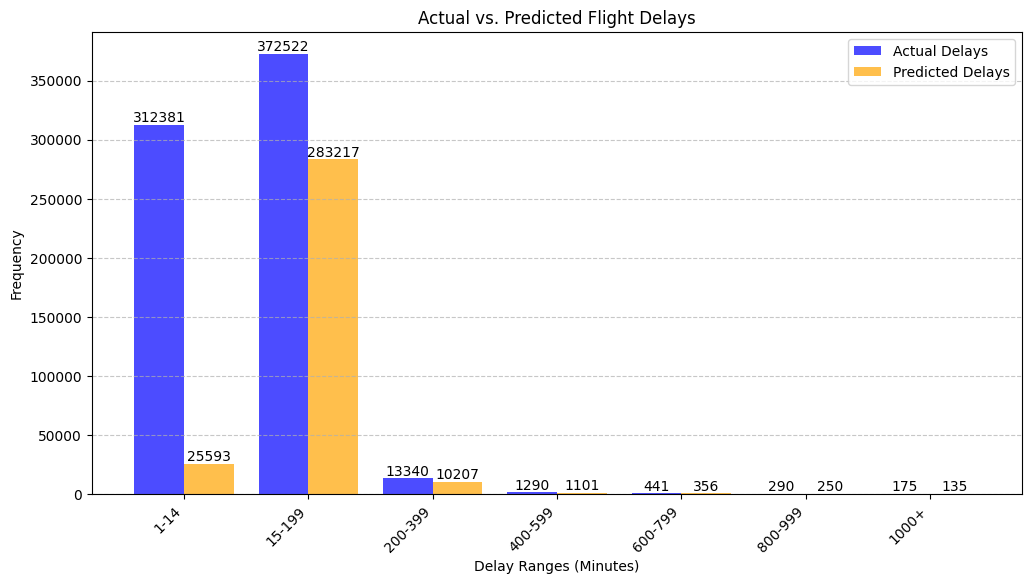

In [5]:
df_actual = pd.read_csv("Preprocessed_Data_Regression.csv")
df_pred = pd.read_csv("final_predictions.csv")

y_actual = df_actual["ArrDelayMinutes"]
y_pred_optimized = df_pred["y_pred_optimized"]

ranges = [(1, 14), (15, 199), (200, 399), (400, 599), (600, 799), (800, 999), (1000, float('inf'))]
bins = [low for low, high in ranges] + [ranges[-1][1]]
bin_labels = [f"{low}-{high}" if high != float('inf') else f"{low}+" for low, high in ranges]

y_actual_filtered = y_actual[y_actual >= 1]

valid_indices = ~np.isnan(y_pred_optimized)
y_pred_filtered = y_pred_optimized[valid_indices]

df_actual_filtered = pd.DataFrame({"Actual": y_actual_filtered})
df_pred_filtered = pd.DataFrame({"Predicted": y_pred_filtered})

df_actual_filtered["Actual_Binned"] = pd.cut(df_actual_filtered["Actual"], bins=bins, labels=bin_labels, right=False)
df_pred_filtered["Predicted_Binned"] = pd.cut(df_pred_filtered["Predicted"], bins=bins, labels=bin_labels, right=False)

actual_counts = df_actual_filtered["Actual_Binned"].value_counts().sort_index()
predicted_counts = df_pred_filtered["Predicted_Binned"].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.4
x = np.arange(len(bin_labels))

bars1 = ax.bar(x - bar_width / 2, actual_counts, bar_width, label="Actual Delays", color="blue", alpha=0.7)
bars2 = ax.bar(x + bar_width / 2, predicted_counts, bar_width, label="Predicted Delays", color="orange", alpha=0.7)

for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', fontsize=10)

ax.set_xlabel("Delay Ranges (Minutes)")
ax.set_ylabel("Frequency")
ax.set_title("Actual vs. Predicted Flight Delays")
ax.set_xticks(x)
ax.set_xticklabels(bin_labels, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()